# Schedules

$ \{ (i,j,k) \to (i+j, k, i) \}$



## Definition
<!-- The iteration domain of statements gives information about the *instances* to be executed but does not specify in which order. -->
statement的iteration domain给出了*instances*的执行信息,但是并没有指定执行顺序.
<!-- In fact, we can specify any piece-wise quasi-linear order by assigning logical execution dates to each statement instance. -->
实际上, 我们可以通过为每个statement instance分配逻辑执行顺序来指定分段 quasi-linear 的顺序。
<!-- Concisely, this *schedule* can be expressed as a Presburger map between statement instances and logical dates. -->
简而言之，此*schedule*可以表示为statement instance和逻辑顺序之间的Presburger映射。


## Identity Schedule
<!-- By default, statement instances are executed following the loop iteration order.
This can be expressed using an *identity* schedule relation. -->
默认情况下，statement instances按照循环迭代顺序执行。
这可以使用*identity* schedule relation来表示。

<!-- For example, the simple initialization loop -->
比如一个简单的循环初始化:
```c
for (i = 0; i < N; ++i)
S:  A[i] = 0.0;
```
<!-- with iteration domain -->
iteration domain:
$( \mathcal{D}\_\mathtt{S} = [N] \rightarrow \{ \mathtt{S}(i) : 0 \leq i < N \} )$

对应的identity schedule:
$( \mathcal{T}\_\mathtt{S} = [N] \rightarrow \{ \mathtt{S}(i) \rightarrow (t_0) : t_0 = i \} )$.

In *isl* notation:


In [1]:
import islpy as isl
D_S = isl.Set("[N] -> { S[i]: 0 <= i < N }") # 迭代域
T_S = isl.Map("[N] -> {S[i] -> [t0]: t0 = i}") # schedule
print(T_S)

[N] -> { S[i] -> [t0 = i] }


## Multidimensional Schedules

<!-- If a statement instance is identified by a vector of more than one element, i.e. the statement is enclosed in multiple nested loops, it is usually mapped to a *multidimensional* logical dates. -->

如果一个statement instance由多个元素的向量标识, 则表示这个statement包含在多个嵌套循环中，它通常映射到*multidimensional*逻辑顺序。

<!-- In this case, the statement instances are executed following the *lexicographical order* of their logical dates. -->
下面的例子中, statement instances以逻辑顺序的*lexicographical order*进行执行.
<!-- For example, the date $((0,42))$ precedes the date $((100,0))$.  We denote this as $((0,42) \prec (100,0))$. -->
比如$((0,42))$在$((100,0))$之前, 写作$((0,42) \prec (100,0))$.
<!-- The lexicographical order is usually extended to compare vectors of different size. -->
lexicographical order通常扩展到比较不同大小的向量。
<!-- A shorter vector that is a prefix of a longer vector precedes it, for example $((0,42) \prec (0,42,0))$. -->
短的的向量，是和较长向量的前缀比较，例如$((0,42) \prec (0,42,0))$.

<!-- For example, zero-initialization of a two-dimensional array -->
比如, 多维下的初始化:
```c
for (i = 0; i < N; ++i)
  for (j = 0; j < N; ++j)
S:  A[i][j] = 0.0;
```
<!-- has the iteration domain -->
iteration domain:
$( \mathcal{D}_\mathtt{S} = [N] \rightarrow \{ \mathtt{S}(i): 0 \leq i,j < N \} )$
<!-- will have the identity schedule -->
identity schedule:
$( \mathcal{T}_\mathtt{S} = [N] \rightarrow \{ \mathtt{S}(i,j) \rightarrow (t_0, t_1) : t_0 = i \wedge t_1 = j \} )$.

In *isl* notation:

In [2]:
D_S = isl.Set("[N] -> {S[i,j]: 0 <= i,j < N}")
T_S = isl.Map("[N] -> {S[i,j] -> [t0,t1]: t0 = i and t1 = j}")
print(T_S)

[N] -> { S[i, j] -> [t0 = i, t1 = j] }


<!-- Even if in theory the schedule can be expressed using a single dimension -->
即使理论上schedule可以用单维度来表示:
$( \mathcal{T}_\mathtt{S} = [N] \rightarrow \{ \mathtt{S}(i,j) \rightarrow (t_0) : t_0 = Ni + j \} )$
<!-- such expression cannot be represented as a Presburger map due to multiplication of the variables.
However, such schedules can be constructed when the actual constant is used instead of a constant parameter. -->
但由于存在变量的乘法，这种表达式是不能表示为Presburger映射的.

不过当使用实际常量而不是常量参数时，是可以构建这样的schedule的.

### Question
<!-- Propose an identity schedule for the initialization loop of a three-dimensional array -->
写出三维数组循环初始化的identity schedule
```c
for (i = 0; i < N; ++i)
  for (j = 0; j < N; ++j)
    for (k = 0; k < N; ++k)
T:    A[i][j] = 0.0;
```

In [3]:
D_T = isl.Set("[N] -> { A[i,j,k] : 0 <= i,j,k < N }")
T_T = isl.Map("[N] -> { A[i,j,k] -> [t0 = i,t1 = j,t2 = k] }")
T_T

Map("[N] -> { A[i, j, k] -> [t0 = i, t1 = j, t2 = k] }")

### Question
<!-- Try defining a one-dimensional schedule with multiplication for the same domain (error expected). -->
尝试为同一域定义一个具有乘法的一维计划（会出现错误）。

In [4]:
try:
  T_T_err = isl.Map("[N] -> {S[i,j,k] -> [t0]: t0 = N*N*i + N*j + k}")
except:
  print("got error")

got error


## Representing Lexical Order
<!-- Consider the loop nest with two statements -->
考虑一个循环中包含两个statement:
```c
for (i = 0; i < 10; ++i) {
P:  A[i] = 0.0;
Q:  B[i] = 1.0;
}
```
<!-- Using plain identity schedule for both statement would result in them having *identical* dates. -->
对两个statement使用简单的identity schedule将导致他们具有*相同的*执行顺序.
<!-- Yet it is clear from the code that instances of `Q` are executed *after* the respective instances of `P`.
This *lexical order* of the statements can be encoded in the schedule relations using an *auxiliary* dimension. -->
然而，从代码中可以清楚地看出，`Q`的是在`P`之后执行的, statement的*lexical order*可以使用*auxiliary*维度在schedule中编码.
<!-- It is assigned a constant so as to force instances of `P` to be executed before instances of `Q`,
i.e. the constant for `P` is smaller than the one for `Q`. -->
他分配一个常量，以便在`Q`之前强制执行`P`的statement, 即`P`的常数小于`Q`的常数。

<!-- Because the order exists *inside* the loop, the auxiliary dimension is placed after the loop dimension. -->
由于顺序存在于循环中*内部*，因此辅助维度放置在循环维度之后。
$( \mathcal{T} = 
  \{ P(i) \rightarrow (t\_0, t\_1) : t\_0 = i \wedge t\_1 = 0 \} \cup
  \{ Q(i) \rightarrow (t\_0, t\_1) : t\_0 = i \wedge t\_1 = 1 \} )$
<!-- This map will assign dates $((i,0))$ to the instances of `P` and dates $((i,1))$ to the instances of `Q`. -->
这个map会将顺序$((i,0))$分配到`P`, 然后$((i,1))$分配到`Q`.
<!-- It is clear that $( \forall i, (i,0) \prec (i,1) )$. -->
从而清晰的表示$( \forall i, (i,0) \prec (i,1) )$
<!-- In *isl*, schedules for different statements can be combined into a union map. -->
*isl*中, 不同的 statements的schedules 可以被结合为 union map.

In [5]:
D = isl.UnionSet("{P[i]: 0 <= i < 10; Q[i]: 0 <= i < 10}") # 首先列出两个statement的set
S = isl.UnionMap("{P[i] -> [t0,t1]: t0 = i and t1 = 0; Q[i] -> [t0,t1]: t0 = i and t1 = 1}") # 为他们分别分配额外的执行顺序, P = 0, Q = 1
print(S)

{ Q[i] -> [t0 = i, t1 = 1]; P[i] -> [t0 = i, t1 = 0] }


### 
<!-- Consider the SCoP with two loops -->
考虑两个循环组成的`SCoP`
```c
for (i = 0; i < 10; ++i) {
U:  A[i] = 0.0;
}
for (i = 0; i < 10; ++i) {
V:  B[i] = 1.0;
}
```
<!-- In this case, *all* instances of `U` are executed before *any* instance of `V`. -->
这个例子中,*所有的*`U`的实例都在*所有的*`V`的实例之前执行,
<!-- Therefore, the auxiliary dimension is introduced *before* the loop dimension. -->
因此辅助维度会在循环维度之前加入:

$( \mathcal{T} =
  \{ \mathtt{U}(i) \rightarrow (t_0, t_1) : t_0 = 0 \wedge t_1 = i \} \cup
  \{ \mathtt{V}(i) \rightarrow (t_0, t_1) : t_0 = 1 \wedge t_1 = i \}.
)$

Or, in *isl* notation:


In [6]:
D2 = isl.UnionSet("{U[i]: 0 <= i < 10; V[i]: 0 <= i < 10}") # 两个statement分别的set
S2 = isl.UnionMap("{U[i] -> [t0,t1]: t0 = 0 and t1 = i; V[i] -> [t0,t1]: t0 = 1 and t1 = i}") # 这里把t1作为loop 维度, t0作为辅助维度, 也就是表示两个statement执行循环顺序相同,但是执行整个循环的顺序不同.
print(S2)

{ U[i] -> [t0 = 0, t1 = i]; V[i] -> [t0 = 1, t1 = i] }


<!-- ###  -->
<!-- Plotting the *scheduled domain* can help to see the difference. -->
绘制两个*scheduled domain*可以发现不同:


{ [t0, t1 = 1] : 0 <= t0 <= 9; [t0, t1 = 0] : 0 <= t0 <= 9 }


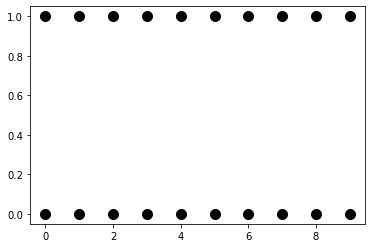

In [7]:
from islplot.plotter import *
plot_set_points(D.apply(S))
print(D.apply(S)) # t0表示是外部循环的顺序, t1 表示的内部statement的执行顺序, 此时外部循环0~9, 内部执行顺序0~1

{ [t0 = 1, t1] : 0 <= t1 <= 9; [t0 = 0, t1] : 0 <= t1 <= 9 }


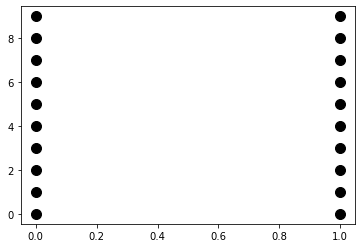

In [8]:
plot_set_points(D2.apply(S2))
print(D2.apply(S2)) # t0表示是循环外部的顺序, t1表示循环内statement的执行顺序, 此时循环外部有先后顺序, 循环内顺序 0~9


<!-- Note that the logical dates live in the *same* space for all statements, therefore one cannot tell them apart visually. -->
注意, 因为上面将logical dates和所有statement的实例绘制在同一个space中,所以比较难辨认.


### Question
<!-- Generally, an auxiliary dimension is included *after* the last loop the statements share. -->
通常,如果auxiliary dimension被statement共享, 那么定义在循环的最内部, 
<!-- If they do not share any loop, it comes foremost. -->
如果没有被任何loop共享, 那么放到最前面.
<!-- Define the identity schedule with auxiliary dimensions for the SCoP. -->
为下面的schedule定义auxiliary dimension:
```c
for (i = 0; i < 10; ++i) {
  for (j = 0; j < 5; ++j)
S1: A[i][j] = 0.;
  for (j = 0; j < 5; ++j)
S2: B[i][j] = 0.;
}
```

In [9]:
D = isl.UnionSet("{ S1[i,j] : 0 <= i < 10 and 0 <= j < 5 ; S2[i,j] : 0 <= i < 10 and 0 <= j < 5 }")
S = isl.UnionMap("{ S1[i,j] -> [t0 = i,t1 = 0,t2 = j]; S2[i,j] -> [t0 = i,t1 = 1,t2 = j]; }")
print(S) # t0 作为共享循环i, t1 控制循环j外部的顺序, t2 分别为每个循环j的顺序.

{ S1[i, j] -> [t0 = i, t1 = 0, t2 = j]; S2[i, j] -> [t0 = i, t1 = 1, t2 = j] }
